In [1]:
!nvidia-smi

Thu Sep 23 10:21:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install git+https://github.com/alexus37/MasterThesisCode.git#egg=deepexplain

  Cloning https://github.com/alexus37/MasterThesisCode.git to /tmp/pip-install-fj0l0sza/deepexplain_3d85010ca4d34b2287ee0533629c9ee4
  Running command git clone -q https://github.com/alexus37/MasterThesisCode.git /tmp/pip-install-fj0l0sza/deepexplain_3d85010ca4d34b2287ee0533629c9ee4
  Created wheel for deepexplain: filename=deepexplain-0.3-py3-none-any.whl size=33172 sha256=93d91a7488642663cf522a58f4eec5dd78dbb40f815ee501a480c2d9ca92daf9
  Stored in directory: /tmp/pip-ephem-wheel-cache-tdteeyxr/wheels/b7/5f/5b/3f0104a275ea017edb3d7f12160edd759e35aa67ab7c55b9c4
Successfully built deepexplain


In [3]:
!pip -q install mne

     |████████████████████████████████| 6.9 MB 5.4 MB/s 


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm


def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

In [5]:
# import tensorflow and disable eager execution right up front
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample


from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.compat.v1.keras.backend as K
from tensorflow.keras.models import Model


from deepexplain.tf.v2_x import DeepExplain
# while the default tensorflow ordering is 'channels_last' we set it here
# to be explicit in case if the user has changed the default ordering
K.set_image_data_format('channels_last')

##################### Process, filter and epoch the data ######################
data_path = sample.data_path()

# Set parameters and read data
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
tmin, tmax = -0., 1
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)

# Setup for reading the raw data
raw = io.Raw(raw_fname, preload=True, verbose=False)
raw.filter(2, None, method='iir')  # replace baselining with high-pass
events = mne.read_events(event_fname)

raw.info['bads'] = ['MEG 2443']  # set bad channels
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True, verbose=False)
labels = epochs.events[:, -1]

# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels

kernels, chans, samples = 1, 60, 151

# take 50/25/25 percent of the data to train/validate/test
X_train      = X[0:144,]
Y_train      = y[0:144]
X_validate   = X[144:216,]
Y_validate   = y[144:216]
X_test       = X[216:,]
Y_test       = y[216:]

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train-1)
Y_validate   = np_utils.to_categorical(Y_validate-1)
Y_test       = np_utils.to_categorical(Y_test-1)

# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
   
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

Using tf version = 2.6.0
Using tf version = 2.6.0
Using default location ~/mne_data for sample...
Creating ~/mne_data


  0%|          | Downloading : 0.00/1.54G [00:00<?,        ?B/s]

Verifying hash 12b75d1cb7df9dfb4ad73ed82f61094f.
Decompressing the archive: /root/mne_data/MNE-sample-data-processed.tar.gz
(please be patient, this can take some time)
Successfully extracted to: ['/root/mne_data/MNE-sample-data']
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
X_train shape: (144, 60, 151, 1)
144 train samples
72 test samples


In [6]:
# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
model = EEGNet(nb_classes = 4, Chans = chans, Samples = samples, 
               dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

###############################################################################
# if the classification task was imbalanced (significantly more trials in one
# class versus the others) you can assign a weight to each class during 
# optimization to balance it out. This data is approximately balanced so we 
# don't need to do this, but is shown here for illustration/completeness. 
###############################################################################

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:1, 1:1, 2:1, 3:1}

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 5, 
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer], class_weight = class_weights)

Train on 144 samples, validate on 72 samples
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 1.38636, saving model to /tmp/checkpoint.h5
144/144 - 33s - loss: 1.3995 - accuracy: 0.2292 - val_loss: 1.3864 - val_accuracy: 0.2361
Epoch 2/5

Epoch 00002: val_loss did not improve from 1.38636
144/144 - 0s - loss: 1.3733 - accuracy: 0.3264 - val_loss: 1.3864 - val_accuracy: 0.2361
Epoch 3/5

Epoch 00003: val_loss did not improve from 1.38636
144/144 - 0s - loss: 1.3627 - accuracy: 0.3889 - val_loss: 1.3864 - val_accuracy: 0.2361
Epoch 4/5

Epoch 00004: val_loss did not improve from 1.38636
144/144 - 0s - loss: 1.3425 - accuracy: 0.3819 - val_loss: 1.3864 - val_accuracy: 0.2361
Epoch 5/5

Epoch 00005: val_loss did not improve from 1.38636
144/144 - 0s - loss: 1.3430 - accuracy: 0.4097 - val_loss: 1.3864 - val_accuracy: 0.2361


In [8]:
with DeepExplain(session = K.get_session()) as de:
	input_tensor   = model.layers[0].input
	fModel         = Model(inputs = input_tensor, outputs = model.layers[-2].output)    
	target_tensor  = fModel(input_tensor)    

	# can use epsilon-LRP as well if you like.
	attributions   = de.explain('deeplift', target_tensor * Y_test, input_tensor, X_test)
	# attributions = de.explain('elrp', target_tensor * Y_test, input_tensor, X_test)

/usr/local/lib/python3.7/dist-packages/deepexplain/tf/v2_x/main.py:97: UserWarning: DeepExplain detected you are trying to use an attribution method that requires gradient override but the original gradient was used instead. You might have forgot to (re)create your graph within the DeepExlain context. Results are not reliable!
  warnings.warn('DeepExplain detected you are trying to use an attribution method that requires '


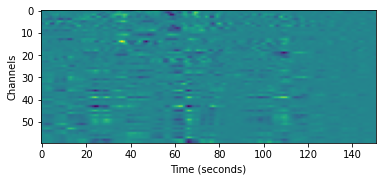

In [18]:
import matplotlib.pyplot as plt

plt.imshow(attributions[0, :, :].squeeze())
plt.xlabel('Time (seconds)')
plt.ylabel('Channels')
plt.show()
